In [2]:
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns

In [3]:
# Pull the CSV and check out the layout.

raw_cars_df = pd.read_csv("../data/cars-dataset.csv")

raw_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
102,26.0,4,97.0,46.00,1950.0,21.0,73,2,volkswagen super beetle
105,13.0,8,360.0,170.0,4654.0,13.0,73,1,plymouth custom suburb
47,19.0,6,250.0,100.0,3282.0,15.0,71,1,pontiac firebird
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
384,32.0,4,91.0,67.00,1965.0,15.7,82,3,honda civic (auto)
119,20.0,4,114.0,91.00,2582.0,14.0,73,2,audi 100ls
342,30.0,4,135.0,84.00,2385.0,12.9,81,1,plymouth reliant
264,18.1,8,302.0,139.0,3205.0,11.2,78,1,ford futura
163,18.0,6,225.0,95.00,3785.0,19.0,75,1,plymouth fury
182,28.0,4,107.0,86.00,2464.0,15.5,76,2,fiat 131


In [4]:
"""
The data is mostly good, but some of the horsepowers are missing. The dataset is small enough
that I don't want to just drop the whole row, but leaving the value set for "?" will cause problems.
So we're going to impute the missing values by replacing the "?" with mean/median horsepower values.

To reduce margin of error I'll use the mean values from the same origin and number of cylinders.
"""

# Replace "?" with NaN so we can use fillna() later
raw_cars_df['horsepower'] = raw_cars_df['horsepower'].replace('?', pd.NA)

# Convert horsepower to numeric, forcing errors to NaN
raw_cars_df['horsepower'] = pd.to_numeric(
    raw_cars_df['horsepower'], errors='coerce')

# This function will replace all the missing horsepower values with 
# mean values based on cylinder and origin.
# So like a 6 cylinder vehicle from Europe will get a mean of other 
# 6 cylinder horsepowers from europe.
def impute_missing_hp(row, grouped_means):
    if pd.isna(row['horsepower']):
        return grouped_means.loc[(row['cylinders'], row['origin'])]
    return row['horsepower']

# Calculate the mean horsepower for each cylinders-origin group
grouped_means = raw_cars_df.groupby(['cylinders', 'origin'])[
    'horsepower'].mean()

# Use the imput_missing_hp function on every row
raw_cars_df['horsepower'] = raw_cars_df.apply(
    lambda row: impute_missing_hp(row, grouped_means), axis=1)

all_cars_df = raw_cars_df

all_cars_df.sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
172,25.0,4,90.0,71.0,2223.0,16.5,75,2,volkswagen dasher
203,29.5,4,97.0,71.0,1825.0,12.2,76,2,volkswagen rabbit
223,15.5,8,318.0,145.0,4140.0,13.7,77,1,dodge monaco brougham
276,21.6,4,121.0,115.0,2795.0,15.7,78,2,saab 99gle
140,14.0,8,304.0,150.0,4257.0,15.5,74,1,amc matador (sw)
169,20.0,6,232.0,100.0,2914.0,16.0,75,1,amc gremlin
279,29.5,4,98.0,68.0,2135.0,16.6,78,3,honda accord lx
270,21.1,4,134.0,95.0,2515.0,14.8,78,3,toyota celica gt liftback
48,18.0,6,250.0,88.0,3139.0,14.5,71,1,ford mustang
192,22.0,6,250.0,105.0,3353.0,14.5,76,1,chevrolet nova


In [20]:
# Here's a separate dataframe for each origin.

american_cars_df = all_cars_df[all_cars_df['origin']== 1]

european_cars_df = all_cars_df[all_cars_df['origin'] == 2]

japanese_cars_df = all_cars_df[all_cars_df['origin'] == 3]

european_cars_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
19,26.0,4,97.0,46.000000,1835.0,20.5,70,2,volkswagen 1131 deluxe sedan
20,25.0,4,110.0,87.000000,2672.0,17.5,70,2,peugeot 504
21,24.0,4,107.0,90.000000,2430.0,14.5,70,2,audi 100 ls
22,25.0,4,104.0,95.000000,2375.0,17.5,70,2,saab 99e
23,26.0,4,121.0,113.000000,2234.0,12.5,70,2,bmw 2002
...,...,...,...,...,...,...,...,...,...
354,34.5,4,100.0,78.311475,2320.0,15.8,81,2,renault 18i
359,28.1,4,141.0,80.000000,3230.0,20.4,81,2,peugeot 505s turbo diesel
360,30.7,6,145.0,76.000000,3160.0,19.6,81,2,volvo diesel
375,36.0,4,105.0,74.000000,1980.0,15.3,82,2,volkswagen rabbit l


In [6]:
# These should be gone now.
missing_hp_df = all_cars_df[all_cars_df['horsepower']=='?']

missing_hp_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name


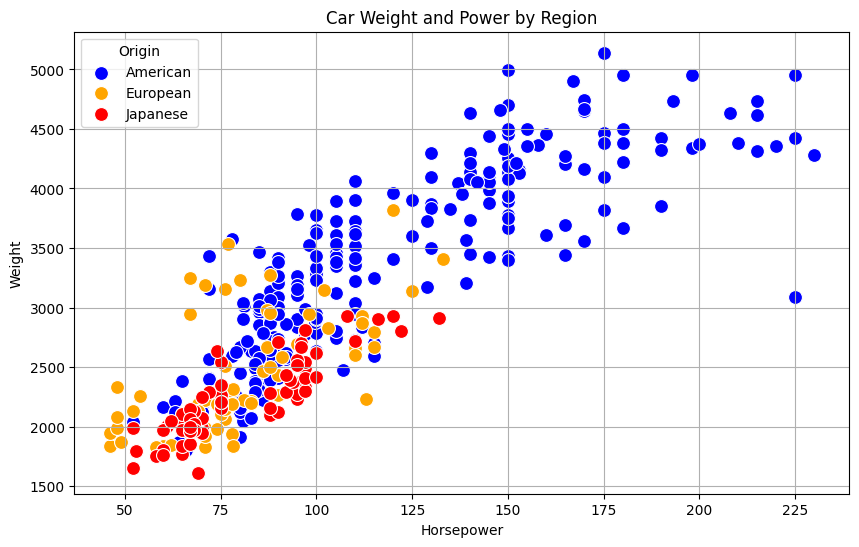

In [22]:
plt.figure(figsize=(10, 6))

# American cars
scatter1 = sns.scatterplot(data=american_cars_df, x='horsepower',
                           y='weight', color='blue', label='American', s=100)

# European cars
scatter2 = sns.scatterplot(data=european_cars_df, x='horsepower',
                           y='weight', color='orange', label='European', s=100)

# Japanese cars
scatter3 = sns.scatterplot(data=japanese_cars_df, x='horsepower',
                           y='weight', color='red', label='Japanese', s=100)

plt.title('Car Weight and Power by Region')
plt.xlabel('Horsepower')
plt.ylabel('Weight')
plt.grid(True)

# Show the legend
plt.legend(title='Origin')

# Show the plot
plt.show()

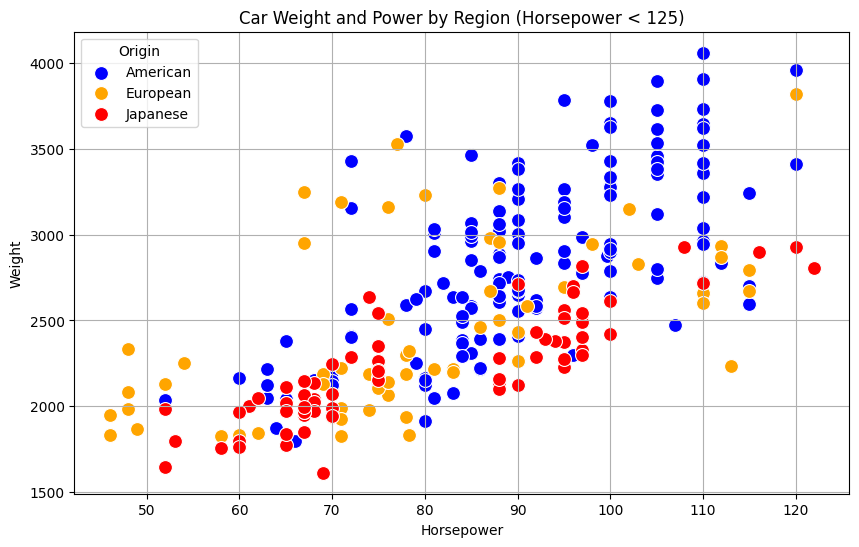

In [23]:
# Filter each dataframe for cars with less than 125 horsepower
american_cars_lt_125 = american_cars_df[american_cars_df['horsepower'] < 125]
european_cars_lt_125 = european_cars_df[european_cars_df['horsepower'] < 125]
japanese_cars_lt_125 = japanese_cars_df[japanese_cars_df['horsepower'] < 125]

plt.figure(figsize=(10, 6))

# American cars
scatter1 = sns.scatterplot(data=american_cars_lt_125, x='horsepower',
                           y='weight', color='blue', label='American', s=100)

# European cars
scatter2 = sns.scatterplot(data=european_cars_lt_125, x='horsepower',
                           y='weight', color='orange', label='European', s=100)

# Japanese cars
scatter3 = sns.scatterplot(data=japanese_cars_lt_125, x='horsepower',
                           y='weight', color='red', label='Japanese', s=100)

plt.title('Car Weight and Power by Region (Horsepower < 125)')
plt.xlabel('Horsepower')
plt.ylabel('Weight')
plt.grid(True)

# Show the legend
plt.legend(title='Origin')

# Show the plot
plt.show()

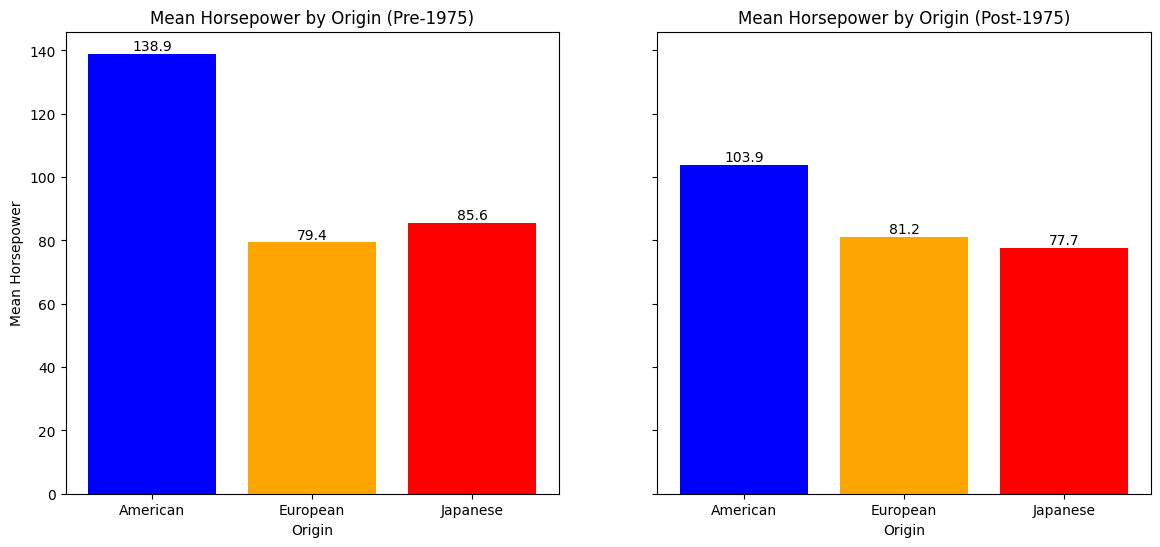

In [26]:
# Split before and after 75
pre_75_df = raw_cars_df[raw_cars_df['model'] < 75]
post_75_df = raw_cars_df[raw_cars_df['model'] >= 75]

# Grab the mean for each split
mean_hp_pre_75 = pre_75_df.groupby('origin')['horsepower'].mean().reset_index()
mean_hp_post_75 = post_75_df.groupby(
    'origin')['horsepower'].mean().reset_index()

# Put the lables on the origins
origin_labels = {1: 'American', 2: 'European', 3: 'Japanese'}
mean_hp_pre_75['origin'] = mean_hp_pre_75['origin'].map(origin_labels)
mean_hp_post_75['origin'] = mean_hp_post_75['origin'].map(origin_labels)

# Raise the bar...graph
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Pre-75 bar graph
bars1 = axes[0].bar(mean_hp_pre_75['origin'],
                    mean_hp_pre_75['horsepower'], color=['blue', 'orange', 'red'])
axes[0].set_title('Mean Horsepower by Origin (Pre-1975)')
axes[0].set_xlabel('Origin')
axes[0].set_ylabel('Mean Horsepower')

# Adding values on top of bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height,
                 f'{height:.1f}', ha='center', va='bottom')

# Post-75 bar graph
bars2 = axes[1].bar(mean_hp_post_75['origin'],
                    mean_hp_post_75['horsepower'], color=['blue', 'orange', 'red'])
axes[1].set_title('Mean Horsepower by Origin (Post-1975)')
axes[1].set_xlabel('Origin')

# Adding values on top of bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height,
                 f'{height:.1f}', ha='center', va='bottom')


plt.show()